Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

home = getcwd()
choice = gui.ask_load_or_begin()
folders = files.Paths(home)
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        if file_name.endswith(".stl") or file_name.endswith(".STL"):
            folders.create_layers_3d(path_input, dpi, layer_height, file_name, folders)
        else:
            folders.create_layers_2d(path_input, dpi, layer_height, file_name, folders)
    layer.divide_islands(folders)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
First arg: /home/matheus/Downloads/Tangran3/TangranV2/input/stl_models/Garvata.STL
Second arg: 300.0
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/input/sliced
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2
Script executed from: /home/matheus/Downloads/Tangran3/TangranV2/slicing-with-images
number of degenerated triangles = 0
eps = 0.004
max thickness = 2
rounded plane spacing spacing = 2
model zmin = 0, model zmax = 10, first plane Z = -1.996, number of planes = 7
-Incremental, Garvata.STL, thickness = 2, #T = 324, #P = 5, #S = 800, 0.000239s (slicing), 0.001391s (polygon assembling), 0.004412s (total), *K: 2.46914


rm: cannot remove '*.svg': No such file or directory
rm: cannot remove '*.png': No such file or directory




writing image: ../input/sliced/layer_000.pgm


writing image: ../input/sliced/layer_001.pgm


writing image: ../input/sliced/layer_002.pgm


writing image: ../input/sliced/layer_003.pgm


writing image: ../input/sliced/layer_004.pgm


writing output file: out_3d.svg
... done


Total de [Fase 0: ] : 1.8369450569152832


Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"

%reset_selective -f "camadas"
%reset_selective -f "c"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
salvando imagens das regiões
Total de [salvando imagens das regiões] : 3.981590270996094e-05
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.036232948303222656
Total de [Criando paredes finas] : 6.66252875328064
Total de [Fase 1: Camada: 0] : 6.6796605587005615
Fase 1: Camada: 1
Criando paredes finas
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou contorno
teste: caso de uma unica linha no entorno 

Contornos

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
        print("pausa")
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 6
Total de [Criando Lvls] : 3.9565165042877197
Criando os loops
Total de [Criando os loops] : 2.700564384460449
Criando regiões de influência
Total de [Criando regiões de influência] : 0.41834473609924316
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.919214963912964
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:3070 maior void:0.9673776662484316Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:6118 maior void:1.932245922208281Bw -> bloqueado
['Lvl_002', 0, 0] Perdendo total:18354 maior void:16.179422835633627Bw -> bloqueado
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_002', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_003', 0, 0] Perdendo total:11313 maior void:8.973651191969887Bw -

Pontes

In [4]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        c.make_bridges(n_max, nozzle_diam_internal, folders)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.9544754028320312
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 11.01078200340271
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_002') Maior prioridade: 1
Total de [Criando pontes de Crossover] : 0.17440032958984375
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.025079011917114258
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.34452247619628906
Total de [Fase 3: Camada: 0] : 12.574270486831665
Fase 3: Camada: 1
Criando pontes de Offset
Total de [Criando pontes de Offset] : 0.930084228515625
Criando pontes de Zigzag
Total de [Criando pontes de Zigzag] : 11.437175512313843
Criando pontes de Crossover
Elemento: ('Reg_000', 'Reg_002') Maior prioridade: 1
Total de [Criando pontes de Crossover] : 0.3211343288421631
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.035616397857666016
salvando imagens das regiões
Total de 

Zigzags

In [5]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 14.186300992965698
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.2606954574584961
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.08567523956298828
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.1405184268951416
Total de [Fase 4: Camada: 0] : 14.881338357925415
Fase 4: Camada: 1
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 7.711607456207275
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.18880581855773926
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.07709503173828125
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.11719489097595215
Total de [Fase 4: Camada: 1] : 8.289666414260864
Fase 4: Camada: 2
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 13.932762384414673
Criando os grafos de regiões

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.4724764823913574
Fase 4: Camada: 1


Total de [Fase 4: Camada: 1] : 0.43122029304504395
Fase 4: Camada: 2


Total de [Fase 4: Camada: 2] : 0.4362776279449463
Fase 4: Camada: 3


Total de [Fase 4: Camada: 3] : 0.33115243911743164
Fase 4: Camada: 4


Total de [Fase 4: Camada: 4] : 0.44182610511779785


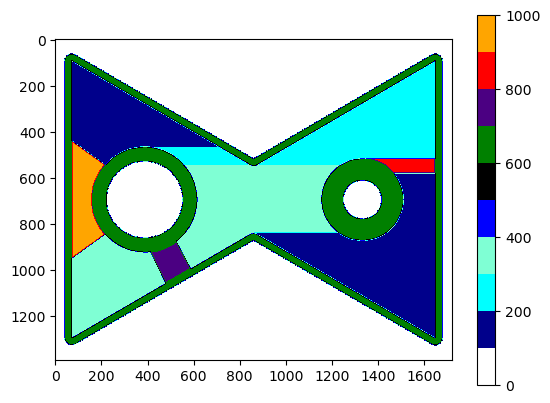

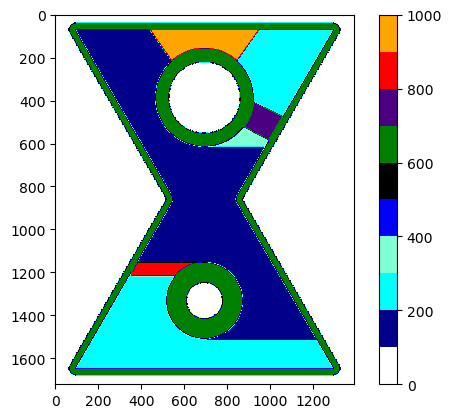

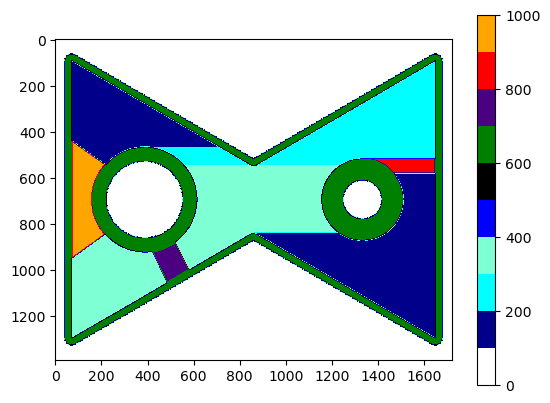

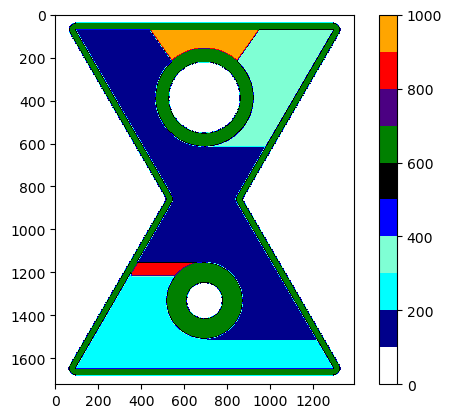

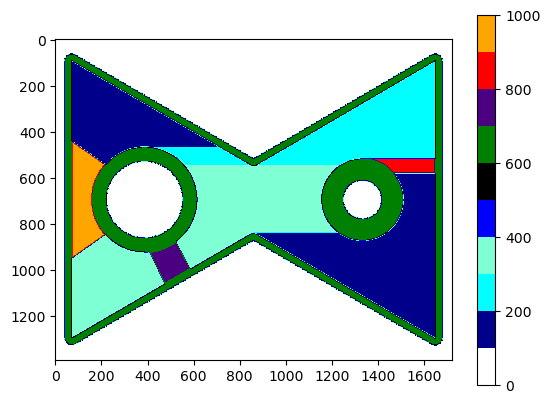

In [1]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        # os.chdir(folders.output)
        # plt.imsave(f"mapping_{folders.save_file_name.replace(".hdf5","")}_{c.name}.png", img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        # os.chdir(folders.home)
        print('\n')

# %reset_selective -f "camadas"
# %reset_selective -f "c"

In [16]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


ROTAS

Rotas de Offset

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making offset routes"):
            c.make_offset_routes(amendment_size, folders)

Fase 5
Making offset routes
Total de [Making offset routes] : 5.360267162322998
Total de [Fase 5] : 5.3605170249938965
Fase 5
Making offset routes
Total de [Making offset routes] : 5.607902526855469
Total de [Fase 5] : 5.608141899108887
Fase 5
Making offset routes
Total de [Making offset routes] : 5.614617586135864
Total de [Fase 5] : 5.615081310272217
Fase 5
Making offset routes
Total de [Making offset routes] : 5.459327220916748
Total de [Fase 5] : 5.459746599197388
Fase 5
Making offset routes
Total de [Making offset routes] : 5.339243412017822
Total de [Fase 5] : 5.339402437210083


Rotas de pontes

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making bridges routes"):
            c.make_bridges_routes(folders)

Fase 5
Making bridges routes
Total de [Making bridges routes] : 14.765148162841797
Total de [Fase 5] : 14.765734672546387
Fase 5
Making bridges routes
Total de [Making bridges routes] : 14.536877870559692
Total de [Fase 5] : 14.537357807159424
Fase 5
Making bridges routes
Total de [Making bridges routes] : 14.158326864242554
Total de [Fase 5] : 14.158470869064331
Fase 5
Making bridges routes
Total de [Making bridges routes] : 7.5349156856536865
Total de [Fase 5] : 7.535094499588013
Fase 5
Making bridges routes
Total de [Making bridges routes] : 16.042452573776245
Total de [Fase 5] : 16.04296088218689


Rotas de Ziguezague

In [4]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making zigzag routes"):
            c.zigzags.make_routes_z(c.base_frame, 
                                    c.path_radius_internal)
            c.zigzags.connect_zigzags(c, c.base_frame, c.path_radius_internal, c.mask_full_int, c.zigzags_mst)
        plt.figure()
        plt.imshow(it.final_routes(c))

Fase 5
Making zigzag routes
Total de [Making zigzag routes] : 3.0994415283203125e-05
Total de [Fase 5] : 0.0002677440643310547


AttributeError: 'Layer' object has no attribute 'zigzags'

Weaving

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

internal_weaving = 1
for c in camadas:
    with Timer("Fase 6 b"):
        c.internal_weaving(internal_weaving)
        c.internal_weaving(internal_weaving)
    plt.figure()
    plt.imshow(it.final_routes(c))

Rotas de Thin Walls

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
from components import path
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

fator_epsilon_ext = 0.01
fator_epsilon_int = 0.01
fator_epsilon_par = 0.1

for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.thin_walls.make_routes_tw(c.path_radius, 
                                           c.base_frame, 
                                           c.rest_of_picture_f2, 
                                           c.odd_layer, 
                                           c.offsets.all_valid_loops)
    plt.figure()
    plt.imshow(it.phase5_result(c))

Unificando rotas EXTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external()
    plt.figure()
    plt.imshow(c.external_tree_route.get_img(c.base_frame))
    

Unificando rotas INTERNAS nas camadas

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal()
    plt.figure()
    plt.imshow(c.internal_tree_route.get_img(c.base_frame))

Unindo rotas de thin walls

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls()

Unindo todas as rotas e criando codigo G

In [ ]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
from components import path

if not('folders' in globals()):
    home = getcwd()
    folders = files.Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 9"):
        c.close_final_path()
    print('\n \n \n')
path.layers_to_Gcode(camadas, folders)
# layers_to_Gcode(camadas, arquivos)